# Libraries and Setup

In [145]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from scipy import stats

%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

cmap1 = "Blues"

# Import and Explore
## 1. Know Your Data
### 1.1. Import and Setup

In [146]:
# import data
train_target = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [147]:
# store train and test length
len_train = train_target.shape[0]
len_test = test.shape[0]
# separate train target
target = train_target['Survived']
train = train_target.drop('Survived', axis=1)
# create full dataset for EDA
data = pd.concat((train, test), axis=0)

In [148]:
# re-index
data.reset_index(inplace=True, drop=True)

In [149]:
# checkpoint
train.shape
test.shape
data.shape

(891, 11)

(418, 11)

(1309, 11)

### 1.2. Explore Data Structure

In [150]:
train_target.sample(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
495,496,0,3,"Yousseff, Mr. Gerious",male,NaN,0,0,2627,14.4583,NaN,C
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.0,1,2,113781,151.5500,C22 C26,S
64,65,0,1,"Stewart, Mr. Albert A",male,NaN,0,0,PC 17605,27.7208,NaN,C
686,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
577,578,1,1,"Silvey, Mrs. William Baird (Alice Munger)",female,39.0,1,0,13507,55.9000,E44,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
842,843,1,1,"Serepeca, Miss. Augusta",female,30.0,0,0,113798,31.0000,NaN,C


In [151]:
train_target.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [152]:
train_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Text(0.5, 1.0, 'Age Distribution')

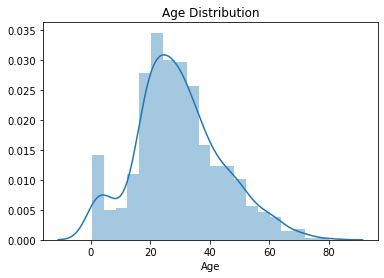

In [153]:
# lots of children on-board
sns.distplot(train_target['Age']).set_title('Age Distribution')

Why did someone pay over $500 for their fare?

Text(0.5, 1.0, 'Fare Distribution')

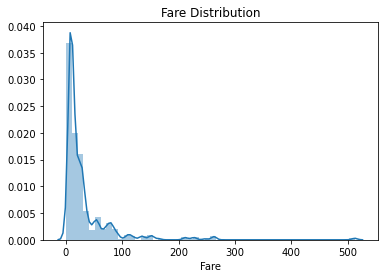

In [154]:
# serious outliers in ticket fare
sns.distplot(train_target['Fare']).set_title('Fare Distribution')

In [155]:
# distribution of categorical features
cols = train_target.columns.tolist()
remove = ['PassengerId', 'Name', 'Age', 'Ticket', 'Fare', 'Cabin']
cat_cols = cols
for ele in remove:
    cat_cols.remove(ele)
# 60% passengers died
# uneven class distribution
for col in cat_cols:
    train_target[col].value_counts()

0    549
1    342
Name: Survived, dtype: int64

3    491
1    216
2    184
Name: Pclass, dtype: int64

male      577
female    314
Name: Sex, dtype: int64

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

S    644
C    168
Q     77
Name: Embarked, dtype: int64

### 1.3. Explore Feature Relationships
#### x = sex + class | y = survival

Text(0.5, 1.0, 'Survival Rate by Sex and Economic Class')

Text(0, 0.5, 'Survival Rate')

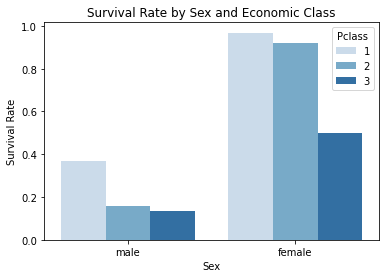

In [156]:
# middle and upper class females took priority
ax = sns.barplot(x='Sex', y='Survived', hue='Pclass', data=train_target, ci=None, palette=cmap1)
ax.set_title('Survival Rate by Sex and Economic Class')
ax.set_ylabel('Survival Rate')

#### x = age + class | y = survival

In [157]:
# group passengers by age
train_target['AgeGrp'] = pd.cut(x=train_target['Age'], bins=[0, 17, 35, 60, 100], labels=['Child', 'YngAdult', 'OldAdult', 'Elderly'])

Text(0.5, 1.0, 'Survival Rate by Age and Economic Class')

Text(0.5, 0, 'Age Group')

Text(0, 0.5, 'Survival Rate')

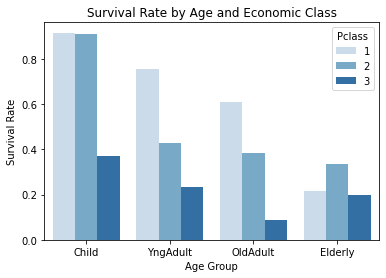

In [158]:
# younger passengers took priority
ax = sns.barplot(x='AgeGrp', y='Survived', hue='Pclass', data=train_target, ci=None, palette=cmap1)
ax.set_title('Survival Rate by Age and Economic Class')
ax.set_xlabel('Age Group')
ax.set_ylabel('Survival Rate')

Text(0.5, 1.0, 'Survival Rate by Sex and Economic Class')

Text(0, 0.5, 'Survival Rate')

Text(0.5, 1.0, 'Survival Rate by Age and Economic Class')

Text(0.5, 0, 'Age Group')

Text(0, 0.5, '')

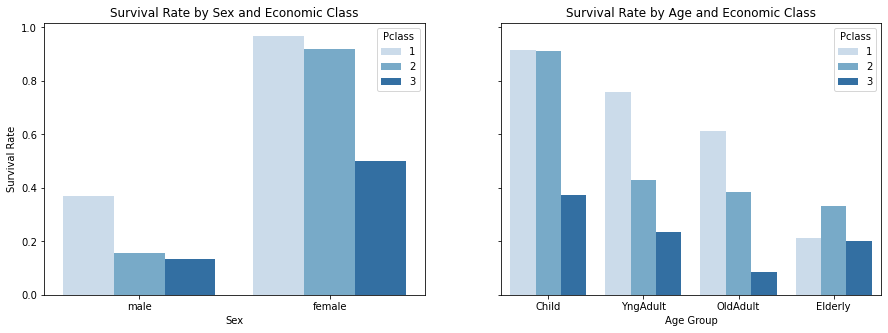

In [159]:
# joint figure
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15, 5))
sns.barplot(x='Sex', y='Survived', hue='Pclass', data=train_target, ci=None, palette=cmap1, ax=ax1)
ax1.set_title('Survival Rate by Sex and Economic Class')
ax1.set_ylabel('Survival Rate')
sns.barplot(x='AgeGrp', y='Survived', hue='Pclass', data=train_target, ci=None, palette=cmap1, ax=ax2)
ax2.set_title('Survival Rate by Age and Economic Class')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('')

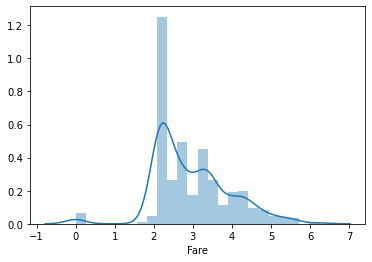

In [160]:
# fix fare skew
fare_log = np.log1p(train_target['Fare'])
sns.distplot(fare_log)

#### x = fare | y = survival

Text(0.5, 1.0, 'Passenger Fare by Fate')

Text(0, 0.5, 'Fare (log(x+1))')

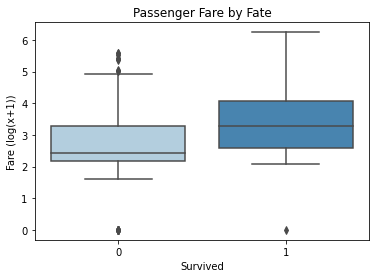

In [161]:
# minimal influence of fare on survival
ax = sns.boxplot(x=train_target['Survived'], y=fare_log, palette=cmap1)
ax.set_title('Passenger Fare by Fate')
ax.set_ylabel('Fare (log(x+1))')

In [162]:
# check NULLS for cabin assignments
print('Cabin, Percent NULL: {}'.format(train_target['Cabin'].isnull().sum()/len(train_target)*100))

Cabin, Percent NULL: 77.10437710437711


#### x = embarkment + class | y = survival

In [163]:
embark_df = pd.pivot_table(train_target, values=['Survived', 'PassengerId'], index=['Embarked', 'Pclass'], 
                           aggfunc={'Survived': np.mean, 'PassengerId': pd.Series.nunique}, margins=True, margins_name='Total')
embark_df.reset_index(inplace=True)
embark_df.rename(columns={'Embarked':'Location', 'Pclass':'Class', 'PassengerId':'Count', 
                          'Survived':'% Survived'})

,Location,Class,Count,% Survived
0,C,1,85,0.694118
1,C,2,17,0.529412
2,C,3,66,0.378788
3,Q,1,2,0.500000
4,Q,2,3,0.666667
5,Q,3,72,0.375000
6,S,1,127,0.582677
7,S,2,164,0.463415
8,S,3,353,0.189802
9,Total,,889,0.382452


In [164]:
pd.pivot_table(train_target, values='Survived', index='Pclass', aggfunc=np.mean)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [165]:
# some tickets were shared
train_target['Ticket'].nunique()

681

## 2. Clean Your Data

I like to track issues I find as I go, so when it's time to clean the dataset I have somewhere to start.
- Address NULLs
- Split 'Cabin' into Deck, Rm_Num
- Split 'Name' into Title, Last
- Change 'Ticket' to 'Party'
- Streamline Dataset

### 2.1. Address NULLs

In [166]:
# create table of % NULLs
pd.DataFrame({'Percent_NULL': (data.isnull().sum()/len(data)*100).sort_values(ascending=False)}).head(4)

,Percent_NULL
Cabin,77.463713
Age,20.091673
Embarked,0.152788
Fare,0.076394


The majority of cabin assignments are unknown. However, considering the importance of a passengers' location on the ship when it began to sink, I think this variable still has value. I will assign NULL values a 'U' for unknown.

In [167]:
data = data.fillna(value={'Cabin':'U'})

I know age was an important predictor of survival. Maybe we could use other information (like 'Name') to place passengers whose age is NULL into an age group. Again, I will assign a placeholder 'U' to NULL values for now.

In [168]:
data['Age'].fillna('U', inplace=True)

Embarkment location only has a few missing values, so I will fill those with the median.
Fare also only has a few missing values, so I will fill those with the mean.
NOTE: Splitting and rejoining after the fill to avoid slippage.

In [169]:
# split data
train = data[:len_train]
test = data[-len_test:]
# fill NAs
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)
test['Embarked'].fillna(test['Embarked'].mode()[0], inplace=True)
train['Fare'].fillna(train['Fare'].mean(), inplace=True)
test['Fare'].fillna(test['Fare'].mean(), inplace=True)
# join data
data = pd.concat((train, test), axis=0)

C:\Users\Work\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [170]:
# check NULLS
pd.DataFrame({'Percent_NULL': (data.isnull().sum()/len(data)*100).sort_values(ascending=False)}).head(4)

,Percent_NULL
Embarked,0.0
Cabin,0.0
Fare,0.0
Ticket,0.0


### 2.2. Split Cabin Info

Cabin values (ex. A35) contain two different pieces of information: deck (A) and cabin number (35). I expect deck and cabin number to inform the models in different ways, so I want them to have their own columns.

In [171]:
data['Deck'] = data['Cabin'].apply(lambda x: re.findall(r"\D", x)[0])
data['CabinNum'] = data['Cabin'].apply(lambda x: re.findall(r"\d{1,500}", x))
data['CabinCnt'] = data['CabinNum'].apply(lambda x: len(x) if len(x)>0 else 'U')
data['CabinNum'] = data['CabinNum'].apply(lambda x: x[0] if len(x)>0 else 'U')

In [172]:
data.drop(columns=['Cabin', 'Fare'], inplace=True)

### 2.3. Split Name Info

I want to pull and parse 'Name' and keep the pieces I think are informative.

In [173]:
data['Last'] = data['Name'].apply(lambda x: x.split(',', 2)[0])
data['Name'] = data['Name'].apply(lambda x: x.split(',', 2)[1])
data['Title'] = data['Name'].apply(lambda x: x.split('.', 2)[0])

In [174]:
# drop original column
data.drop(columns=['Name'], inplace=True)

In [175]:
# clean up title
data['Title'].nunique()
titles = data['Title'].value_counts().reset_index(name='count').query('count>10')['index'].tolist()
data['Title'] = data['Title'].apply(lambda x: x if x in titles else 'Other')
print('Titles with >10 Records: {}'.format(titles))

18

Titles with >10 Records: [' Mr', ' Miss', ' Mrs', ' Master']


### 2.4. Change Ticket
Tickets might contain information about party size. Traveling alone vs in a party might impact survival.

In [176]:
data['Party'] = data['Ticket'].apply(lambda x: 1 if x in data['Ticket'].value_counts().reset_index(name='count')\
                              .query('count>1')['index'].tolist() else 0)

In [177]:
relations_rows = list(np.where((data['Parch']>0) | (data['SibSp']>0))[0])

In [178]:
for row in relations_rows:
    data.at[row, 'Party']=1

### 2.5. Streamline Dataset

In [179]:
# rename columns
data = data.rename(columns={'PassengerId':'ID', 'Sex':'Gender', 'Pclass':'Class', 'CabinNum':'Cabin', 'Parch':'ParCh'})

In [180]:
# drop uninformative columns
data = data.drop(columns=['Ticket', 'CabinCnt'])

In [181]:
# re-order columns
order = ['ID', 'Title', 'Last', 'Gender', 'Age', 'SibSp', 'ParCh', 'Party', 'Class', 'Deck', 'Cabin', 'Embarked']
data = data[order]

In [182]:
# make columns numeric
data['Gender'] = data['Gender'].replace({'male':1, 'female':0})
data['Deck'] = data['Deck'].replace({'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8, 'U':8})

## 3. Visualize Your Data

In [183]:
# re-create train_target dataset
train_target = pd.concat((data[:len_train], target), axis=1)

### 3.1. Influence of Title on Survival Rate

Text(0.5, 0, 'Title')

Text(0, 0.5, 'Survival Rate')

Text(0.5, 1.0, 'Survival Rate by Title and Economic Class')

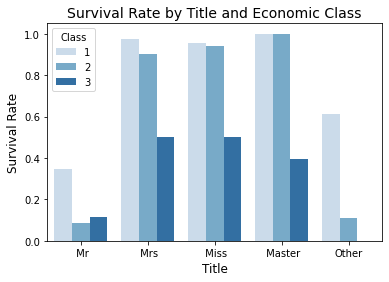

In [184]:
ax = sns.barplot(x='Title', y='Survived', hue='Class', data=train_target, ci=None, palette=cmap1)
ax.set_xlabel('Title', fontsize=12)
ax.set_ylabel('Survival Rate', fontsize=12)
ax.set_title('Survival Rate by Title and Economic Class', fontsize=14)

### 3.2. Influence of Cabin Location on Survival Rate

In [185]:
# create cabin number subset
train_cabin = train_target.loc[train_target['Cabin'] != 'U'].copy()
train_cabin['Cabin'] = train_cabin['Cabin'].astype(int)

Text(0.5, 1.0, 'Mean Cabin Number by Survived')

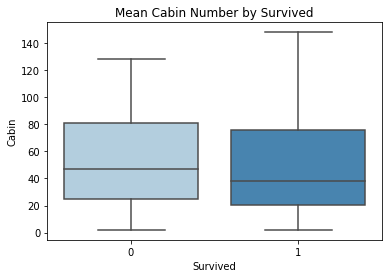

In [186]:
ax = sns.boxplot(x='Survived', y='Cabin', data=train_cabin, palette=cmap1)
ax.set_title('Mean Cabin Number by Survived')

In [187]:
# create deck subset
train_deck = train_target.loc[train_target['Deck'] != 8].copy()

Text(0.5, 1.0, 'Survival Rate by Deck')

[(0.0, 1.0)]

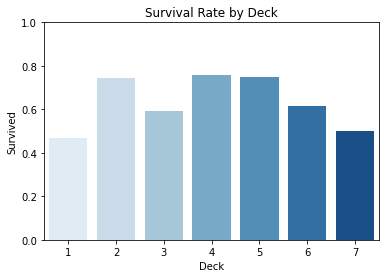

In [188]:
ax = sns.barplot(x='Deck', y='Survived', data=train_deck, ci=None, palette=cmap1)
ax.set_title('Survival Rate by Deck')
ax.set(ylim=(0, 1))

### 3.3. Relationship Between Deck and Class

In [189]:
# deck distribution by class
deck_dist = pd.pivot_table(train_target, values=['ID'], index=['Deck'], columns=['Class'], dropna=False, fill_value=0,
                           aggfunc={'ID':pd.Series.nunique}, margins=True, margins_name='Total')
deck_dist.rename(columns={'ID':''})

Class    1    2    3 Total
Deck                      
1       15    0    0    15
2       47    0    0    47
3       59    0    0    59
4       29    4    0    33
5       25    4    3    32
6        0    8    5    13
7        0    0    4     4
8       41  168  479   688
Total  216  184  491   891

### 3.4. Influence of Relations on Survival Rate

[(0.0, 1.0)]

Text(0.5, 1.0, 'Influence of Party on Survival Rate')

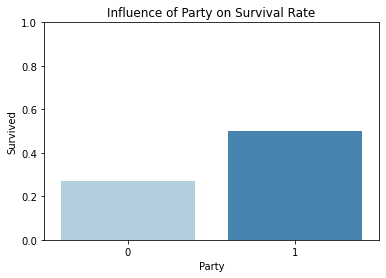

In [190]:
ax = sns.barplot(x='Party', y='Survived', data=train_target, ci=None, palette=cmap1)
ax.set(ylim=(0, 1))
ax.set_title('Influence of Party on Survival Rate')

[(0.0, 1.0)]

Text(0.5, 1.0, 'Survival by Number of Sib/Sp On-board')

Text(0.5, 1.0, 'Survival by Number of Par/Ch On-board')

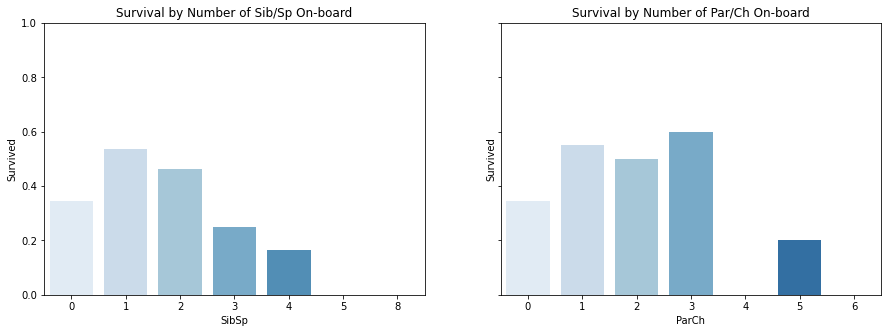

In [192]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15, 5))
sns.barplot(x='SibSp', y='Survived', data=train_target, ci=None, palette=cmap1, ax=ax1)
sns.barplot(x='ParCh', y='Survived', data=train_target, ci=None, palette=cmap1, ax=ax2)
ax1.set(ylim=(0, 1))
ax1.set_title('Survival by Number of Sib/Sp On-board')
ax2.set_title('Survival by Number of Par/Ch On-board')

In [201]:
# check dataset
train_target.sample(8)
train_target.info()

,ID,Title,Last,Gender,Age,SibSp,ParCh,Party,Class,Deck,Cabin,Embarked,Survived
108,109,Mr,Rekic,1,38,0,0,0,3,8,U,S,0
743,744,Mr,McNamee,1,24,1,0,1,3,8,U,S,0
271,272,Mr,Tornquist,1,25,0,0,1,3,8,U,S,1
227,228,Mr,Lovell,1,20.5,0,0,0,3,8,U,S,0
732,733,Mr,Knight,1,U,0,0,0,2,8,U,S,0
592,593,Mr,Elsbury,1,47,0,0,0,3,8,U,S,0
113,114,Miss,Jussila,0,20,1,0,1,3,8,U,S,0
83,84,Mr,Carrau,1,28,0,0,1,1,8,U,S,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        891 non-null    int64 
 1   Title     891 non-null    object
 2   Last      891 non-null    object
 3   Gender    891 non-null    int64 
 4   Age       891 non-null    object
 5   SibSp     891 non-null    int64 
 6   ParCh     891 non-null    int64 
 7   Party     891 non-null    int64 
 8   Class     891 non-null    int64 
 9   Deck      891 non-null    int64 
 10  Cabin     891 non-null    object
 11  Embarked  891 non-null    object
 12  Survived  891 non-null    int64 
dtypes: int64(8), object(5)
memory usage: 90.6+ KB


## 4. Build Models

In [194]:
from sklearn.ensemble import RandomForestClassifier

In [195]:
y_train = train_target['Survived']
x_train = train_target.drop('Survived', axis=1)
test = data[-len_test:]

In [196]:
y_train.shape
x_train.shape
test.shape

(891,)

(891, 12)

(418, 12)

In [197]:
rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rf_clf.fit(x_train, y_train)

ValueError: could not convert string to float: ' Mr'